*********************************4B is not in log form but should be*****************

# Assignment

# Trading Places
1. Read in data using Dask __(1 point)__
2. Descriptive Statistics: __(2 points)__
    
    a. In the year 2012, who were the top 10 countries with the most trading partners? What about the bottom 10?
    
    b. Using the designation [here]( https://www.foreign-trade.com/reference/hscode.htm), describe the trade volume of the whole dataset in terms of value and list the five highest value sectors in the entire sample period.

3. Country statistics: __(3 points)__

    a. Calculate the top 10 exports (in terms of value) of our chosen country in 2012.

    b. Calculate the top 10 goods with the highest trade volume for both exports and imports in terms of:
    
        i. Value
    
        ii. Quantity

3. The Gravity Equation Relationship __(4 points)__

    a. Using the country shapefile, calculate the distance in kilometers between the centroid of our chosen country and all the other centroids. You may use either haversine distance with the geographic CRS or use a projected CRS and use the `distance` function of `geopandas`.
    
    b. Using the country we chose in class, create a scatterplot of distance and export volume (quantity and value) in logarithm form.
    
    c. Calculate the correlations between exports and distance for both value and quantity. Interpret the correlations for each of these factors.
    
    d. Using the designation you created in 2.d., for which sectors are exports (quantity) most strongly related to distance for this country?
    
4. Estimation __(6 points)__
    
    a. Create a function called "SSE_1p" that does the following given a scalar input $\beta$:
        1. Subtracts the logarithm of quantity exports from the logarithm of distance times $\beta$.
$$ e = log(E_{ij}) - \beta log(d_{ij}) $$
        2. Squares the error.
        3. Returns the sum of the squared error. 
    b. Plot the function from -1 to +3 with steps of .005, and then find the minimum of the function with the numpy function "argmin." Is it what you expected?
    
    c. Create another function called "SSE_2p" does the same as "SSE_1p" but instead takes a __vector__ as an argument:
 $$ e = log(E_{ij}) - \beta[0] - \beta[1] log(d_{ij})$$
 
     d. Do a grid search with the first parameter range as 1500 to 2500 in steps of 10, and the second parameter range as -1 to +3 in steps of .005 as before. Do it using either `dask` or `multiprocessing`. Comment on how or why the parameter on $log(d_{ij})$ is different than what you found in part 4b.
     
     e. Now check your results using the "econtools" package "reg" function by running OLS with a constant term.
     
     f. Finally, merge in the GDP numbers from the World Bank and do the regression again, except this time the log of each country's GDP as covariates. How did the coefficient on distance change?
     
5. An analyst asks you "for which commodity sectors is distance most important in terms of exporting?" Describe what your economic intuition would say about the answer, and then also map out an analysis strategy for answering their question. As usual, describe: __(4 points)__
    - What data you would need.
    - How you would manipulate the data.
    - What analysis you would run.

In [3]:
import glob
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import json
import dask
import geopandas as gp
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt


def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = row
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# Question 1

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=2, memory_limit='3GB')
client

Client Scheduler: tcp://127.0.0.1:56592 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.00 GB


In [20]:
df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')

In [4]:
df.head(5)

,t,i,j,k,v,q
0,2012,4,8,610469,2.734000,0.044
1,2012,4,12,91099,1.185000,1.200
2,2012,4,32,392630,1.274453,0.123
3,2012,4,32,730729,2.018000,0.100
4,2012,4,32,853400,5.530000,0.028


# Question 2

In [5]:
df.partitions[3].compute()

,t,i,j,k,v,q
0,2012,554,36,621520,264.118684,1.524000
1,2012,554,36,621590,13.982460,0.066000
2,2012,554,36,621600,64.804601,1.879000
3,2012,554,36,621710,335.961330,10.766000
4,2012,554,36,621790,5.680674,0.098000
...,...,...,...,...,...,...
1419131,2012,752,381,691200,73.248859,8.535434
1419132,2012,752,381,691310,13.051901,0.096012
1419133,2012,752,381,691390,11.130867,1.116331
1419134,2012,752,381,691490,12.151856,0.719000


In [21]:
df=df.set_index('t',sorted=True)

In [7]:
df.known_divisions

True

### Part A) Top and bottom ten countries by number of trade partners in 2012

In [22]:
df12=df.loc[2012]

In [23]:
df12.head(5)

,i,j,k,v,q
t,,,,,
2012,554,36,621520,264.118684,1.524
2012,554,36,621590,13.982460,0.066
2012,554,36,621600,64.804601,1.879
2012,554,36,621710,335.961330,10.766
2012,554,36,621790,5.680674,0.098


In [24]:
top_importers = df12.groupby('i').i.count().nlargest(10).compute()
top_importers

i
842    326867
826    263243
724    220258
792    176323
757    142958
616    130448
752    128977
764    126442
699    122070
784    115991
Name: i, dtype: int64

In [25]:
bottom_importers = df12.groupby('i').i.count().nsmallest(10).compute()
bottom_importers

i
728     27
876     43
574     44
612     54
585     71
624     73
580     76
798    100
583    103
570    122
Name: i, dtype: int64

In [26]:
top_exporters = df12.groupby('j').i.count().nlargest(10).compute()
top_exporters

j
276    65065
251    57253
842    54406
381    54034
826    50126
528    45953
784    45077
156    44609
58     42266
36     39676
Name: i, dtype: int64

In [27]:
bottom_exporters = df12.groupby('j').i.count().nsmallest(10).compute()
bottom_exporters

j
166     16
666     30
535     36
612     45
520     73
162     75
260    102
86     123
16     126
798    160
Name: i, dtype: int64

### Part b) Trade volume values and five  highes value sectors

In [4]:
df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')

<AxesSubplot:>

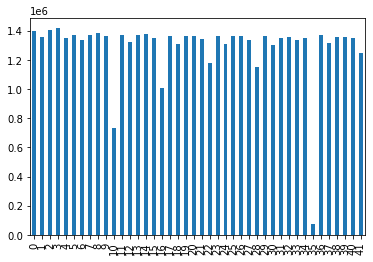

In [9]:
df.map_partitions(len).compute().plot(kind='bar')

<AxesSubplot:>

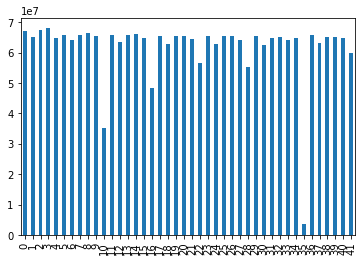

In [10]:
def mem_usage(x): 
    return x.memory_usage().sum()

df.map_partitions(mem_usage).compute().plot(kind='bar')

In [5]:
##Not using k_alt, assuming 5 digit codes are leading zero
df['group']= 'Animal & Animal Products'
df['group']=df['group'].mask(df['k']>=60000, 'Vegetable Products')
df['group']=df['group'].mask(df['k']>=160000, 'Foodstuffs')
df['group']=df['group'].mask(df['k']>=250000, 'Mineral Products')
df['group']=df['group'].mask(df['k']>=280000, 'Chemicals & Allied Industries')
df['group']=df['group'].mask(df['k']>=390000, 'Plastics/Rubbers')
df['group']=df['group'].mask(df['k']>=410000, 'Raw Hides, Skins, Leather, & Furs')
df['group']=df['group'].mask(df['k']>=440000, 'Wood & Wood Products')
df['group']=df['group'].mask(df['k']>=500000, 'Textiles')
df['group']=df['group'].mask(df['k']>=640000, 'Footwear/Headgear')
df['group']=df['group'].mask(df['k']>=680000, 'Stone/Glass')
df['group']=df['group'].mask(df['k']>=720000, 'Metals')
df['group']=df['group'].mask(df['k']>=840000, 'Machinery')
df['group']=df['group'].mask(df['k']>=860000, 'Transportation')
df['group']=df['group'].mask(df['k']>=900000, 'Miscellaneous')

In [6]:
df.head(40)

,t,i,j,k,v,q,group
0,2012,4,8,610469,2.734000,0.044,Textiles
1,2012,4,12,91099,1.185000,1.200,Vegetable Products
2,2012,4,32,392630,1.274453,0.123,Plastics/Rubbers
3,2012,4,32,730729,2.018000,0.100,Metals
4,2012,4,32,853400,5.530000,0.028,Machinery
5,2012,4,32,854140,1.168000,0.069,Machinery
6,2012,4,36,40310,12.526542,3.492,Animal & Animal Products
7,2012,4,36,80212,10.126136,4.120,Vegetable Products
8,2012,4,36,80620,24.379120,34.157,Vegetable Products
9,2012,4,36,81310,13.357418,6.030,Vegetable Products


In [7]:
##Changed groupby to "group" and .count to .sum from noah's code
highest_values = df.groupby("group")['v'].sum().nlargest(5).compute() 

In [8]:
highest_values

group
Machinery                        2.960275e+10
Mineral Products                 1.851935e+10
Transportation                   1.245600e+10
Chemicals & Allied Industries    1.142082e+10
Metals                           8.497413e+09
Name: v, dtype: float64

Disregard all below until next section, just keeping for reference

##disregard, just a previous failed attempt
df['k_sixdigit']=df['k'].mask(df['k']<100000, df['k']*10)
df['k_alt']=df['k']+100000
df.head(40)

##disregard
df['k'].value_counts().compute()

##disregard
##another fail at categories
df['group']= 'Animal & Animal Products'
#df.group.loc[df['k_alt']>=160000]='Vegetable Products'
df['group']=df['group'].mask(df['k_alt']>=160000, 'Vegetable Products')
df['group']=df['group'].mask(df['k_alt']>=260000, 'Foodstuffs')
df['group']=df['group'].mask(df['k_alt']>=350000, 'Mineral Products')
df['group']=df['group'].mask(df['k_alt']>=380000, 'Chemicals & Allied Industries')
df['group']=df['group'].mask(df['k_alt']>=490000, 'Plastics/Rubbers')
df['group']=df['group'].mask(df['k_alt']>=510000, 'Raw Hides, Skins, Leather, & Furs')
df['group']=df['group'].mask(df['k_alt']>=540000, 'Wood & Wood Products')
df['group']=df['group'].mask(df['k_alt']>=600000, 'Textiles')
df['group']=df['group'].mask(df['k_alt']>=740000, 'Footwear/Headgear')
df['group']=df['group'].mask(df['k_alt']>=780000, 'Stone/Glass')
df['group']=df['group'].mask(df['k_alt']>=820000, 'Metals')
df['group']=df['group'].mask(df['k_alt']>=940000, 'Machinery')
df['group']=df['group'].mask(df['k_alt']>=960000, 'Transportation')
df['group']=df['group'].mask(df['k_alt']>=1000000, 'Miscellaneous')

product_codes = pd.read_csv('/Users/carri/ACE_592/Homework_3/product_codes_HS12_V202001.csv')
product_codes = product_codes.rename(columns={'code':'k'})

df_wdes = df.merge(product_codes)

countries = pd.read_csv("/Users/carri/ACE_592/Homework_3/country_codes_V202001.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"i","country_name_full":"name_i"})
df_wdes = df_wdes.merge(countries[['i','name_i']])

countries = pd.read_csv("/Users/carri/ACE_592/Homework_3/country_codes_V202001.csv",encoding = "ISO-8859-1")
countries = countries.rename(columns={"country_code":"j","country_name_full":"name_j"})
df_wdes = df_wdes.merge(countries[['j','name_j']])

Largest_values = df_wdes.groupby("description")['v'].count().nlargest(5).compute()

Largest_values1 = df_wdes.groupby("description")['q'].count().nlargest(5).compute()

Largest_values

Largest_values1

# Question 3

### a) Top 10 exports by value for Brazil

Following 2 cells are failed attempts to find just brazil

df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')
df=df.set_index('t',sorted=True)
df12=df.loc[2012]

#df12=df12.loc[df12['i']=='76']
#df['group']=df['group'].mask(df['k']>=60000, 'Vegetable Products')
df12=df12.mask(df12['i']=='76', df12)

In [67]:
##Looks for only rows where Brazil is exporter
df12 = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI_HS12_Y2012_V202001.csv')
df12_brazil = df12.loc[df12['i']==76]

In [69]:
df12.compute()

,t,i,j,k,v,q
0,2012,4,8,610469,2.734000,0.044
1,2012,4,12,91099,1.185000,1.200
2,2012,4,32,392630,1.274453,0.123
3,2012,4,32,730729,2.018000,0.100
4,2012,4,32,853400,5.530000,0.028
...,...,...,...,...,...,...
1351398,2012,894,854,841459,24.335000,1.000
1351399,2012,894,854,843041,770.661000,18.000
1351400,2012,894,854,846799,29.269000,0.343
1351401,2012,894,854,848140,10.207000,1.341


In [72]:
df12_brazil.compute()

,t,i,j,k,v,q
540595,2012,76,4,20230,517.156000,63.936000
540596,2012,76,4,20712,6394.102000,3880.377000
540597,2012,76,4,20714,682.216000,407.820000
540598,2012,76,4,151219,24.087000,5.760000
540599,2012,76,4,160100,174.125000,119.226000
...,...,...,...,...,...,...
628761,2012,76,894,940340,384.960670,202.885667
628762,2012,76,894,940350,111.593102,82.917865
628763,2012,76,894,940360,295.975989,152.188502
628764,2012,76,894,960500,5.571000,0.412000


In [77]:
productvalues=df12_brazil.groupby('k')['v'].sum().compute()

In [81]:
##This will tell you top 10 exports by value for INDIVIDUAL PRODUCTS
productvalues=productvalues.sort_values(ascending=False)
productvalues.head(10)

k
260111    2.497592e+07
270900    2.086092e+07
120190    1.741984e+07
170114    9.870907e+06
260112    7.571141e+06
230400    6.797181e+06
90111     6.025826e+06
271000    5.525909e+06
100590    5.187145e+06
470329    4.651875e+06
Name: v, dtype: float64

In [82]:
df12_brazil['group']= 'Animal & Animal Products'
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=60000, 'Vegetable Products')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=160000, 'Foodstuffs')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=250000, 'Mineral Products')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=280000, 'Chemicals & Allied Industries')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=390000, 'Plastics/Rubbers')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=410000, 'Raw Hides, Skins, Leather, & Furs')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=440000, 'Wood & Wood Products')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=500000, 'Textiles')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=640000, 'Footwear/Headgear')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=680000, 'Stone/Glass')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=720000, 'Metals')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=840000, 'Machinery')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=860000, 'Transportation')
df12_brazil['group']=df12_brazil['group'].mask(df12_brazil['k']>=900000, 'Miscellaneous')

In [85]:
##This will tell you top 10 exports by value for SECTORS
productvalues=df12_brazil.groupby('group')['v'].sum().compute()
productvalues=productvalues.sort_values(ascending=False)
productvalues.head(10)

group
Mineral Products                 6.260166e+07
Vegetable Products               3.447583e+07
Foodstuffs                       3.357553e+07
Transportation                   1.997924e+07
Machinery                        1.925287e+07
Metals                           1.853616e+07
Animal & Animal Products         1.553371e+07
Chemicals & Allied Industries    1.279888e+07
Wood & Wood Products             9.373039e+06
Plastics/Rubbers                 6.299730e+06
Name: v, dtype: float64

### b) Top 10 goods with highest trade volume in entire dataset in terms of both VALUE and QUANTITY

##### i) Value

In [4]:
df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')

In [5]:
df['group']= 'Animal & Animal Products'
df['group']=df['group'].mask(df['k']>=60000, 'Vegetable Products')
df['group']=df['group'].mask(df['k']>=160000, 'Foodstuffs')
df['group']=df['group'].mask(df['k']>=250000, 'Mineral Products')
df['group']=df['group'].mask(df['k']>=280000, 'Chemicals & Allied Industries')
df['group']=df['group'].mask(df['k']>=390000, 'Plastics/Rubbers')
df['group']=df['group'].mask(df['k']>=410000, 'Raw Hides, Skins, Leather, & Furs')
df['group']=df['group'].mask(df['k']>=440000, 'Wood & Wood Products')
df['group']=df['group'].mask(df['k']>=500000, 'Textiles')
df['group']=df['group'].mask(df['k']>=640000, 'Footwear/Headgear')
df['group']=df['group'].mask(df['k']>=680000, 'Stone/Glass')
df['group']=df['group'].mask(df['k']>=720000, 'Metals')
df['group']=df['group'].mask(df['k']>=840000, 'Machinery')
df['group']=df['group'].mask(df['k']>=860000, 'Transportation')
df['group']=df['group'].mask(df['k']>=900000, 'Miscellaneous')

In [6]:
##Full dataframe top PRODUCTS by VALUE 
productvalues=df.groupby('k')['v'].sum().compute()
productvalues=productvalues.sort_values(ascending=False)
productvalues.head(10)

k
270900    7.912294e+09
271000    5.183260e+09
710812    2.163116e+09
300490    1.922855e+09
870323    1.916191e+09
851712    1.762793e+09
880240    1.045804e+09
847130    1.008797e+09
854239    9.712165e+08
271121    9.706400e+08
Name: v, dtype: float64

In [89]:
##Full dataframe top SECTORS by VALUE 
productvalues=df.groupby('group')['v'].sum().compute()
productvalues=productvalues.sort_values(ascending=False)
productvalues.head(10)

group
Machinery                        2.960275e+10
Mineral Products                 1.851935e+10
Transportation                   1.245600e+10
Chemicals & Allied Industries    1.142082e+10
Metals                           8.497413e+09
Miscellaneous                    6.913126e+09
Stone/Glass                      5.634053e+09
Plastics/Rubbers                 5.398827e+09
Textiles                         5.113506e+09
Vegetable Products               4.066172e+09
Name: v, dtype: float64

##### ii) Quantity

In [7]:
##Full dataframe top PRODUCTS by QUANTITY 
productvalues=df.groupby('k')['q'].sum().compute()
productvalues=productvalues.sort_values(ascending=False)
productvalues.head(10)

k
270900    1.495173e+10
260111    8.972815e+09
271000    8.195312e+09
270112    7.089349e+09
271111    3.977239e+09
220190    3.349428e+09
271121    2.557734e+09
270119    2.518876e+09
251710    1.378689e+09
260112    1.144295e+09
Name: q, dtype: float64

In [8]:
##Full dataframe top SECTORS by QUANTITY 
productvalues=df.groupby('group')['q'].sum().compute()
productvalues=productvalues.sort_values(ascending=False)
productvalues.head(10)

group
Mineral Products                 6.063183e+10
Vegetable Products               6.723821e+09
Foodstuffs                       6.402375e+09
Metals                           5.605434e+09
Chemicals & Allied Industries    5.479474e+09
Wood & Wood Products             4.349994e+09
Plastics/Rubbers                 2.037058e+09
Machinery                        1.451719e+09
Stone/Glass                      1.329269e+09
Transportation                   1.274462e+09
Name: q, dtype: float64

# Question 4) Gravity Equation

### a) Calculate distances from other centroids

In [9]:
countries='/Users/carri/ACE_592/Homework_3/countries.geojson'
country=gp.read_file(countries)

In [10]:
country.loc[country['ADMIN']=='Brazil']

,ADMIN,ISO_A3,geometry
33,Brazil,BRA,"MULTIPOLYGON (((-48.54259 -27.81666, -48.55187..."


<AxesSubplot:>

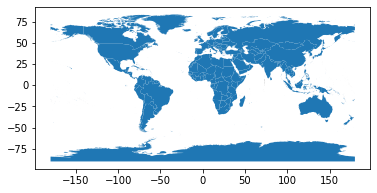

In [11]:
country.plot()

In [12]:
country=country.to_crs(epsg=4087)

<AxesSubplot:>

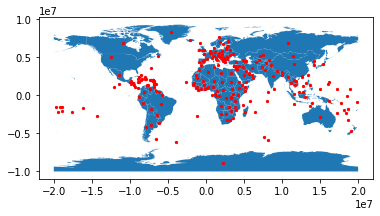

In [13]:
f,a = plt.subplots()
country.plot(ax=a)
country.centroid.plot(ax=a, color='red', markersize=5)

In [14]:
brazilcent=country.centroid[33]

In [15]:
country['brazil_dist'] = country.centroid.distance(brazilcent)/1000 # res is in meters, so converting to km
country.sort_values("brazil_dist").head()

,ADMIN,ISO_A3,geometry,brazil_dist
33,Brazil,BRA,"MULTIPOLYGON (((-5403736.615 -3096536.908, -54...",0.000000
123,Kiribati,KIR,"MULTIPOLYGON (((-16896178.573 -1275129.719, -1...",1280.550147
32,Bolivia,BOL,"POLYGON ((-7268324.496 -1280699.906, -7264438....",1449.285895
186,Paraguay,PRY,"POLYGON ((-6474207.640 -2244771.404, -6474155....",1506.199817
212,Suriname,SUR,"POLYGON ((-6030284.259 595378.510, -6032454.43...",1689.400392


Text(0.5, 1.0, 'Country Centroid Distance from Brazil')

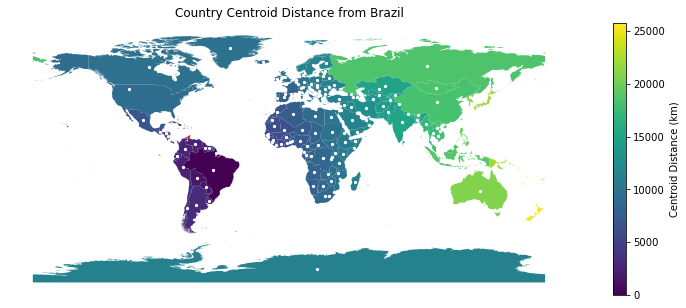

In [16]:
f,a = plt.subplots(figsize=(15,5))
country.plot(column="brazil_dist", # The data it uses to assign colors
                  ax=a,\
                  legend=True,\
                  legend_kwds={'label': "Centroid Distance (km)"});
country.centroid[:1].plot(color="C3",ax=a,markersize=10);
country.centroid[1:].plot(color="w",ax=a,markersize=5);

plt.axis("off");
plt.title("Country Centroid Distance from Brazil")


### b) Create scatterplot with centroid distance (x) and export volume (y, both quantity and value from question 3b) in log form 

NOTE: IT SAYS TO USE LOG FORM BUT I DID NOT FIGURE THAT OUT

In [23]:
country

,ADMIN,ISO_A3,geometry,brazil_dist
0,Aruba,ABW,"POLYGON ((-7792023.454 1400130.035, -7785283.4...",3202.790838
1,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032
2,Angola,AGO,"MULTIPOLYGON (((1306614.688 -1858209.281, 1306...",7864.236441
3,Anguilla,AIA,"MULTIPOLYGON (((-7017321.150 2027457.219, -702...",3414.266868
4,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834
...,...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-19099086.934 -1551589.427, -1...",13258.807650
251,Yemen,YEM,"MULTIPOLYGON (((5934246.071 1349013.509, 59344...",11595.003670
252,South Africa,ZAF,"MULTIPOLYGON (((4214976.725 -5225431.577, 4211...",8936.163482
253,Zambia,ZMB,"POLYGON ((3464244.349 -959198.926, 3466602.913...",9006.978733


In [35]:
countrycodes=pd.read_csv('/Users/carri/ACE_592/Homework_3/country_codes_V202001.csv',encoding='cp1252', low_memory=False)
countrycodes['ISO_A3']=countrycodes['iso_3digit_alpha']

In [37]:
countrycodes

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha,ISO_A3
0,4,Afghanistan,Afghanistan,AF,AFG,AFG
1,8,Albania,Albania,AL,ALB,ALB
2,12,Algeria,Algeria,DZ,DZA,DZA
3,16,American Samoa,American Samoa,AS,ASM,ASM
4,20,Andorra,Andorra,AD,AND,AND
...,...,...,...,...,...,...
222,876,Wallis and Futuna Isds,Wallis and Futuna Islands,WF,WLF,WLF
223,882,Samoa,Samoa,WS,WSM,WSM
224,887,Yemen,Yemen,YE,YEM,YEM
225,891,Serbia and Montenegro,Serbia and Montenegro,CS,SCG,SCG


In [38]:
countrypandas=pd.DataFrame(country)
merged=pd.merge(countrypandas, countrycodes, how='left', on=['ISO_A3'])

In [39]:
merged

,ADMIN,ISO_A3,geometry,brazil_dist,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,Aruba,ABW,"POLYGON ((-7792023.454 1400130.035, -7785283.4...",3202.790838,533.0,Aruba,Aruba,AW,ABW
1,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,4.0,Afghanistan,Afghanistan,AF,AFG
2,Angola,AGO,"MULTIPOLYGON (((1306614.688 -1858209.281, 1306...",7864.236441,24.0,Angola,Angola,AO,AGO
3,Anguilla,AIA,"MULTIPOLYGON (((-7017321.150 2027457.219, -702...",3414.266868,660.0,Anguilla,Anguilla,AI,AIA
4,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834,8.0,Albania,Albania,AL,ALB
...,...,...,...,...,...,...,...,...,...
251,Samoa,WSM,"MULTIPOLYGON (((-19099086.934 -1551589.427, -1...",13258.807650,882.0,Samoa,Samoa,WS,WSM
252,Yemen,YEM,"MULTIPOLYGON (((5934246.071 1349013.509, 59344...",11595.003670,887.0,Yemen,Yemen,YE,YEM
253,South Africa,ZAF,"MULTIPOLYGON (((4214976.725 -5225431.577, 4211...",8936.163482,711.0,So. African Customs Union,Southern African Customs Union,ZA,ZAF
254,Zambia,ZMB,"POLYGON ((3464244.349 -959198.926, 3466602.913...",9006.978733,894.0,Zambia,Zambia,ZM,ZMB


In [64]:
df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')
df_brazil = df.loc[df['i']==76]

In [42]:
df_brazil.head()

,t,i,j,k,v,q
540595,2012,76,4,20230,517.156,63.936
540596,2012,76,4,20712,6394.102,3880.377
540597,2012,76,4,20714,682.216,407.820
540598,2012,76,4,151219,24.087,5.760
540599,2012,76,4,160100,174.125,119.226


In [65]:
brazil_exports_value=df_brazil.groupby('j')['v'].sum().compute()

In [66]:
brazil_exports_quantity=df_brazil.groupby('j')['q'].sum().compute()

In [67]:
brazil_exports_value=pd.DataFrame(brazil_exports_value)

In [68]:
brazil_exports_quantity=pd.DataFrame(brazil_exports_quantity)

In [69]:
brazil_exports_value=brazil_exports_value.reset_index()

In [70]:
brazil_exports_quantity=brazil_exports_quantity.reset_index()

In [71]:
brazil_exports_value=brazil_exports_value.rename(columns={'j':'country_code','v':'exportvalue'})
#brazil_exports_value

In [76]:
brazil_exports_quantity=brazil_exports_quantity.rename(columns={'j':'country_code','q':'exportquantity'})

In [77]:
merged=pd.merge(merged, brazil_exports_value, how='left', on=['country_code'])

In [78]:
merged=pd.merge(merged, brazil_exports_quantity, how='left', on=['country_code'])

In [79]:
merged

,ADMIN,ISO_A3,geometry,brazil_dist,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha,exportvalue_x,exportvalue_y,q,exportvalue,exportquantity
0,Aruba,ABW,"POLYGON ((-7792023.454 1400130.035, -7785283.4...",3202.790838,533.0,Aruba,Aruba,AW,ABW,4.916643e+05,4.916643e+05,8.391470e+05,4.916643e+05,8.391470e+05
1,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,4.0,Afghanistan,Afghanistan,AF,AFG,7.470480e+04,7.470480e+04,6.159404e+04,7.470480e+04,6.159404e+04
2,Angola,AGO,"MULTIPOLYGON (((1306614.688 -1858209.281, 1306...",7864.236441,24.0,Angola,Angola,AO,AGO,6.128687e+06,6.128687e+06,5.612786e+06,6.128687e+06,5.612786e+06
3,Anguilla,AIA,"MULTIPOLYGON (((-7017321.150 2027457.219, -702...",3414.266868,660.0,Anguilla,Anguilla,AI,AIA,4.352144e+03,4.352144e+03,2.469827e+03,4.352144e+03,2.469827e+03
4,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834,8.0,Albania,Albania,AL,ALB,2.801448e+05,2.801448e+05,2.824221e+05,2.801448e+05,2.824221e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,Samoa,WSM,"MULTIPOLYGON (((-19099086.934 -1551589.427, -1...",13258.807650,882.0,Samoa,Samoa,WS,WSM,8.262879e+04,8.262879e+04,2.088712e+04,8.262879e+04,2.088712e+04
252,Yemen,YEM,"MULTIPOLYGON (((5934246.071 1349013.509, 59344...",11595.003670,887.0,Yemen,Yemen,YE,YEM,2.696470e+06,2.696470e+06,5.075920e+06,2.696470e+06,5.075920e+06
253,South Africa,ZAF,"MULTIPOLYGON (((4214976.725 -5225431.577, 4211...",8936.163482,711.0,So. African Customs Union,Southern African Customs Union,ZA,ZAF,1.076245e+07,1.076245e+07,1.164200e+07,1.076245e+07,1.164200e+07
254,Zambia,ZMB,"POLYGON ((3464244.349 -959198.926, 3466602.913...",9006.978733,894.0,Zambia,Zambia,ZM,ZMB,1.005599e+05,1.005599e+05,2.330495e+04,1.005599e+05,2.330495e+04


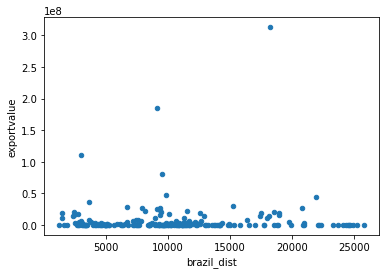

In [82]:
scatter1 = merged.plot.scatter(x='brazil_dist', y='exportvalue')

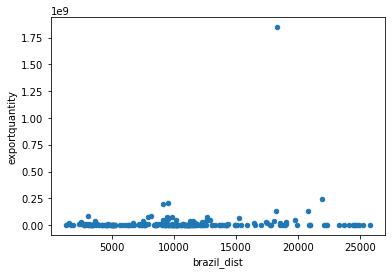

In [83]:
scatter2 = merged.plot.scatter(x='brazil_dist', y='exportquantity')

### c) Correlation exports and distance for both value and quantity, interpret these correlations

In [87]:
merged['brazil_dist'].corr(merged['exportvalue']),merged['brazil_dist'].corr(merged['exportquantity'])

(0.041538610310230005, 0.113138788031847)

These correlation coefficients are unexpected because one would think that a country would trade more heavily with their neighbors, however since there is a positive correlation for both value and quantitiy with distance, it would imply that Brazil generally trades more heavily with countries further away. Brazil is a much larger economy than its geographic neighbors, though, so the correlation is probably skewed by economically large export destinations, such as the US, EU, and China, that are all very far away from Brazil geographically.  

### d) from 2b, which sectors are export quantity most related to distance

In [180]:
df = dd.read_csv('/Users/carri/ACE_592/Homework_3/BACI*.csv')

In [181]:
df['group']= 'Animal & Animal Products'
df['group']=df['group'].mask(df['k']>=60000, 'Vegetable Products')
df['group']=df['group'].mask(df['k']>=160000, 'Foodstuffs')
df['group']=df['group'].mask(df['k']>=250000, 'Mineral Products')
df['group']=df['group'].mask(df['k']>=280000, 'Chemicals & Allied Industries')
df['group']=df['group'].mask(df['k']>=390000, 'Plastics/Rubbers')
df['group']=df['group'].mask(df['k']>=410000, 'Raw Hides, Skins, Leather, & Furs')
df['group']=df['group'].mask(df['k']>=440000, 'Wood & Wood Products')
df['group']=df['group'].mask(df['k']>=500000, 'Textiles')
df['group']=df['group'].mask(df['k']>=640000, 'Footwear/Headgear')
df['group']=df['group'].mask(df['k']>=680000, 'Stone/Glass')
df['group']=df['group'].mask(df['k']>=720000, 'Metals')
df['group']=df['group'].mask(df['k']>=840000, 'Machinery')
df['group']=df['group'].mask(df['k']>=860000, 'Transportation')
df['group']=df['group'].mask(df['k']>=900000, 'Miscellaneous')

In [182]:
df_brazil = df.loc[df['i']==76]
df_brazil=df_brazil.reset_index()

In [146]:
df_brazil.head()

,country_code,group,exportquantity
0,4,Animal & Animal Products,45591.902
1,4,Foodstuffs,1950.388
2,4,Machinery,21.890
3,4,Metals,9.606
4,4,Miscellaneous,1.250


In [104]:
merged=pd.DataFrame(merged)

In [105]:
merged.head()

,ADMIN,ISO_A3,geometry,brazil_dist,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha,exportvalue_x,exportvalue_y,q,exportvalue,exportquantity
0,Aruba,ABW,"POLYGON ((-7792023.454 1400130.035, -7785283.4...",3202.790838,533.0,Aruba,Aruba,AW,ABW,4.916643e+05,4.916643e+05,8.391470e+05,4.916643e+05,8.391470e+05
1,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,4.0,Afghanistan,Afghanistan,AF,AFG,7.470480e+04,7.470480e+04,6.159404e+04,7.470480e+04,6.159404e+04
2,Angola,AGO,"MULTIPOLYGON (((1306614.688 -1858209.281, 1306...",7864.236441,24.0,Angola,Angola,AO,AGO,6.128687e+06,6.128687e+06,5.612786e+06,6.128687e+06,5.612786e+06
3,Anguilla,AIA,"MULTIPOLYGON (((-7017321.150 2027457.219, -702...",3414.266868,660.0,Anguilla,Anguilla,AI,AIA,4.352144e+03,4.352144e+03,2.469827e+03,4.352144e+03,2.469827e+03
4,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834,8.0,Albania,Albania,AL,ALB,2.801448e+05,2.801448e+05,2.824221e+05,2.801448e+05,2.824221e+05


In [183]:
df_brazil=df_brazil.rename(columns={'j':'country_code','q':'exportquantity'})

In [184]:
df_brazil=df_brazil.groupby(['country_code', 'group'])['exportquantity'].sum().compute() 

In [185]:
df_brazil=df_brazil.to_frame()
df_brazil=df_brazil.reset_index()

In [186]:
#merged=pd.merge(merged, brazil_exports_quantity, how='left', on=['country_code'])
df_brazil=pd.merge(df_brazil, merged, how='left', on=['country_code'])
df_brazil.head(20)

,country_code,group,exportquantity,ADMIN,ISO_A3,geometry,brazil_dist,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha,exportvalue_x,exportvalue_y,q,exportvalue_x,exportquantity_x,exportvalue_y,exportquantity_y
0,4,Animal & Animal Products,45591.902000,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,Afghanistan,Afghanistan,AF,AFG,74704.796403,74704.796403,61594.044000,74704.796403,61594.044000,74704.796403,61594.044000
1,4,Foodstuffs,1950.388000,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,Afghanistan,Afghanistan,AF,AFG,74704.796403,74704.796403,61594.044000,74704.796403,61594.044000,74704.796403,61594.044000
2,4,Machinery,21.890000,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,Afghanistan,Afghanistan,AF,AFG,74704.796403,74704.796403,61594.044000,74704.796403,61594.044000,74704.796403,61594.044000
3,4,Metals,9.606000,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,Afghanistan,Afghanistan,AF,AFG,74704.796403,74704.796403,61594.044000,74704.796403,61594.044000,74704.796403,61594.044000
4,4,Miscellaneous,1.250000,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,Afghanistan,Afghanistan,AF,AFG,74704.796403,74704.796403,61594.044000,74704.796403,61594.044000,74704.796403,61594.044000
5,4,Transportation,0.811000,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,Afghanistan,Afghanistan,AF,AFG,74704.796403,74704.796403,61594.044000,74704.796403,61594.044000,74704.796403,61594.044000
6,4,Vegetable Products,12822.560000,Afghanistan,AFG,"POLYGON ((7909227.812 4275632.969, 7910044.680...",14158.036032,Afghanistan,Afghanistan,AF,AFG,74704.796403,74704.796403,61594.044000,74704.796403,61594.044000,74704.796403,61594.044000
7,8,Animal & Animal Products,104647.951445,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834,Albania,Albania,AL,ALB,280144.839677,280144.839677,282422.087217,280144.839677,282422.087217,280144.839677,282422.087217
8,8,Chemicals & Allied Industries,140.047000,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834,Albania,Albania,AL,ALB,280144.839677,280144.839677,282422.087217,280144.839677,282422.087217,280144.839677,282422.087217
9,8,Foodstuffs,164107.671130,Albania,ALB,"POLYGON ((2198311.227 4739861.562, 2198115.639...",9985.559834,Albania,Albania,AL,ALB,280144.839677,280144.839677,282422.087217,280144.839677,282422.087217,280144.839677,282422.087217


In [177]:
#only need to do these once
#df_brazil=df_brazil['exportquantity'].fillna(0)
#df_brazil=df_brazil['brazil_dist_x'].fillna(0)

KeyError: 'brazil_dist_x'

In [190]:
df_brazil['brazil_dist'].loc[df_brazil['group']=='Animal & Animal Products'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Foodstuffs'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Machinery'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Metals'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Miscellaneous'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Transportation'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Vegetable Products'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Chemicals & Allied Industries	'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Wood & Wood Products'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Plastics/Rubbers'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Stone/Glass'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Textiles'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Raw Hides, Skins, Leather, & Furs'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Footwear/Headgear'].corr(df_brazil['exportquantity']),\
df_brazil['brazil_dist'].loc[df_brazil['group']=='Mineral Products'].corr(df_brazil['exportquantity'])



(0.1625441871119378,
 0.11898246950221789,
 -0.13200863276504765,
 -0.028300853143137725,
 -0.23515316221421215,
 -0.128016931422673,
 0.1355922025576321,
 nan,
 0.08700597562955788,
 -0.16519015095678755,
 -0.10532492420688669,
 0.22363440980578506,
 0.1312162862092381,
 -0.17687163414001153,
 0.14912035396004533)

The strongest five correlations by absolute value are Miscellaneous, Textiles, Footwear/Headgear, Plastics/Rubbers, and Animal & Animal Products

# Question 5) Estimation

a)Create a function called "SSE_1p" that does the following given a scalar input  𝛽 :

         1. Subtracts the logarithm of quantity exports from the logarithm of distance times $\beta$.
            𝑒=𝑙𝑜𝑔(𝐸𝑖𝑗)−𝛽𝑙𝑜𝑔(𝑑𝑖𝑗)
 
         2. Squares the error.
         3. Returns the sum of the squared error.

going to assume log base is 10

In [ ]:
#np.log10(14)
def SSE_1p(beta)
    for x in range df_brazil['exportquantity']
        np.log(x)
    y=np.log(df_brazil['brazil_dist'])
    e=x-beta*y
    e=e**2
    

In [201]:
SSE=0
def SSE_1p(beta):
    for z in df_brazil['exportquantity']:
        squared_error=(np.log(df_brazil['brazil_dist'])-beta*np.log(df_brazil['exportquantity'][z]))**2
        SSE=(squared_error+SSE)
    return SSE

In [202]:
x=np.linspace(-1,3,800)
y=SSE_1p(x)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# plot the function
plt.plot(x,y, 'r')
# show the plot
plt.show()

KeyError: 45591.902